## Classify Emails beyond spams - using Hierarchical Clustering 

### This notebook shows the implementation of hierarchical clustering without WSD i.e. Word Sense Disambiguation. The synonyms and hypernyms are not included here. Level 1

### Final Project - Riti Chakraborty

In [1]:
#Riti Chakraborty

#importing the required libraries
import pandas as pd
import numpy as np
from numpy import nan

#For random seed
import random

#To handle warnings
import warnings
warnings.filterwarnings('ignore')

#library used for implementing hierarchical clustering 
import scipy

#For flattening lists
from itertools import chain

#For plotting data
import matplotlib.pyplot as plt


#library for tf-idf vector and other similarities measure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#For implementing Natural Language Processing approaches.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#For using Regular expression
import re

#For Handling Strings
import string


#For implementing word sense disambiguation
from nltk.corpus import wordnet as wn
from wordsegment import load, segment

#Important to call load()
load()

#For LDA Implementation # Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora

#Libraries for hierarchical clustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from collections import defaultdict
from matplotlib.colors import rgb2hex
from matplotlib.colors import colorConverter

#For evaluation Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 



### After Preliminary tests, attributes which didnot contribute in clustering were removed. The attributes mentioned below are the finally chosen ones.

In [9]:
#This file read here, has been generated by the data_preprocess.ipynb.
data_subset=pd.read_csv("../exported_tables/data_subset.csv")
#converting the data in the dataframe into str type
data_subset = data_subset.astype(str) 

#retaining proper index
data_subset=data_subset.reset_index(drop=True)

num_of_rows=len(data_subset.index)

# Converting each row to list of lists
list1=data_subset.values.tolist()
list2=[]

# Converting each sublist into string and storing it in list2
for i in range(0, len(list1)):
    list2.append(' '.join(map(str, list1[i])))

#converting each row into vectors #Printing the count of each term in the emails #Emails on Rows and Terms on columns
vectorizer1 = CountVectorizer()
row_vectors=vectorizer1.fit_transform(list2).todense()


### Defining Function for Stop words removal

In [10]:
def stopword_remove(l2):
    fil_list2=[]
    for sent in l2:
        stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "spam","yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
        word_tokens = word_tokenize(sent.lower())
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []

        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)

        fil_list2.append(' '.join(filtered_sentence))
    return fil_list2
fil_list2=stopword_remove(list2)

### Defining function for punctuation removal

In [11]:
#Function to remove punctuation
def no_punctuation(my_str):
    punctuations = '''!()-[]{};:'"\\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # returning the unpunctuated string
    return no_punct

### Defining function for word segmentation. In the same function, we call the wordnet APIs in the other levels to gather the synonyms and hypernyms of the terms.

In [12]:
#Function for word segmentation and word sense disambiguation
def seg_syn(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    flat_seg_list = [item for sublist in seg for item in sublist]

    return flat_seg_list


In [13]:
#Storing the values returned from the function defined above.
list2_syn=[]
for l in fil_list2:

    #Storing the synonyms and the hypernyms part returned from the previous function
    termz=seg_syn(str(l))
    list2_syn.append(termz)     

flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(ls))

#Converting back to strings
flat_list2_syn=[]
for ls in list2_syn:
    flat_list2_syn.append(' '.join(list(set(ls))))

df_flatlist=pd.DataFrame(flat_list2_syn)
df_flatlist["Index"]=df_flatlist.index

# Hierarchical Clustering

In [14]:
#Unsupervised Kmeans clustering
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(flat_list2_syn)

#Converting to Matrix form
X_matrix=X.todense()

#Terms in overall dataset
terms = vect.get_feature_names()

# Version 1
# H. Clustering using ward linkage and Euclidean distance metric

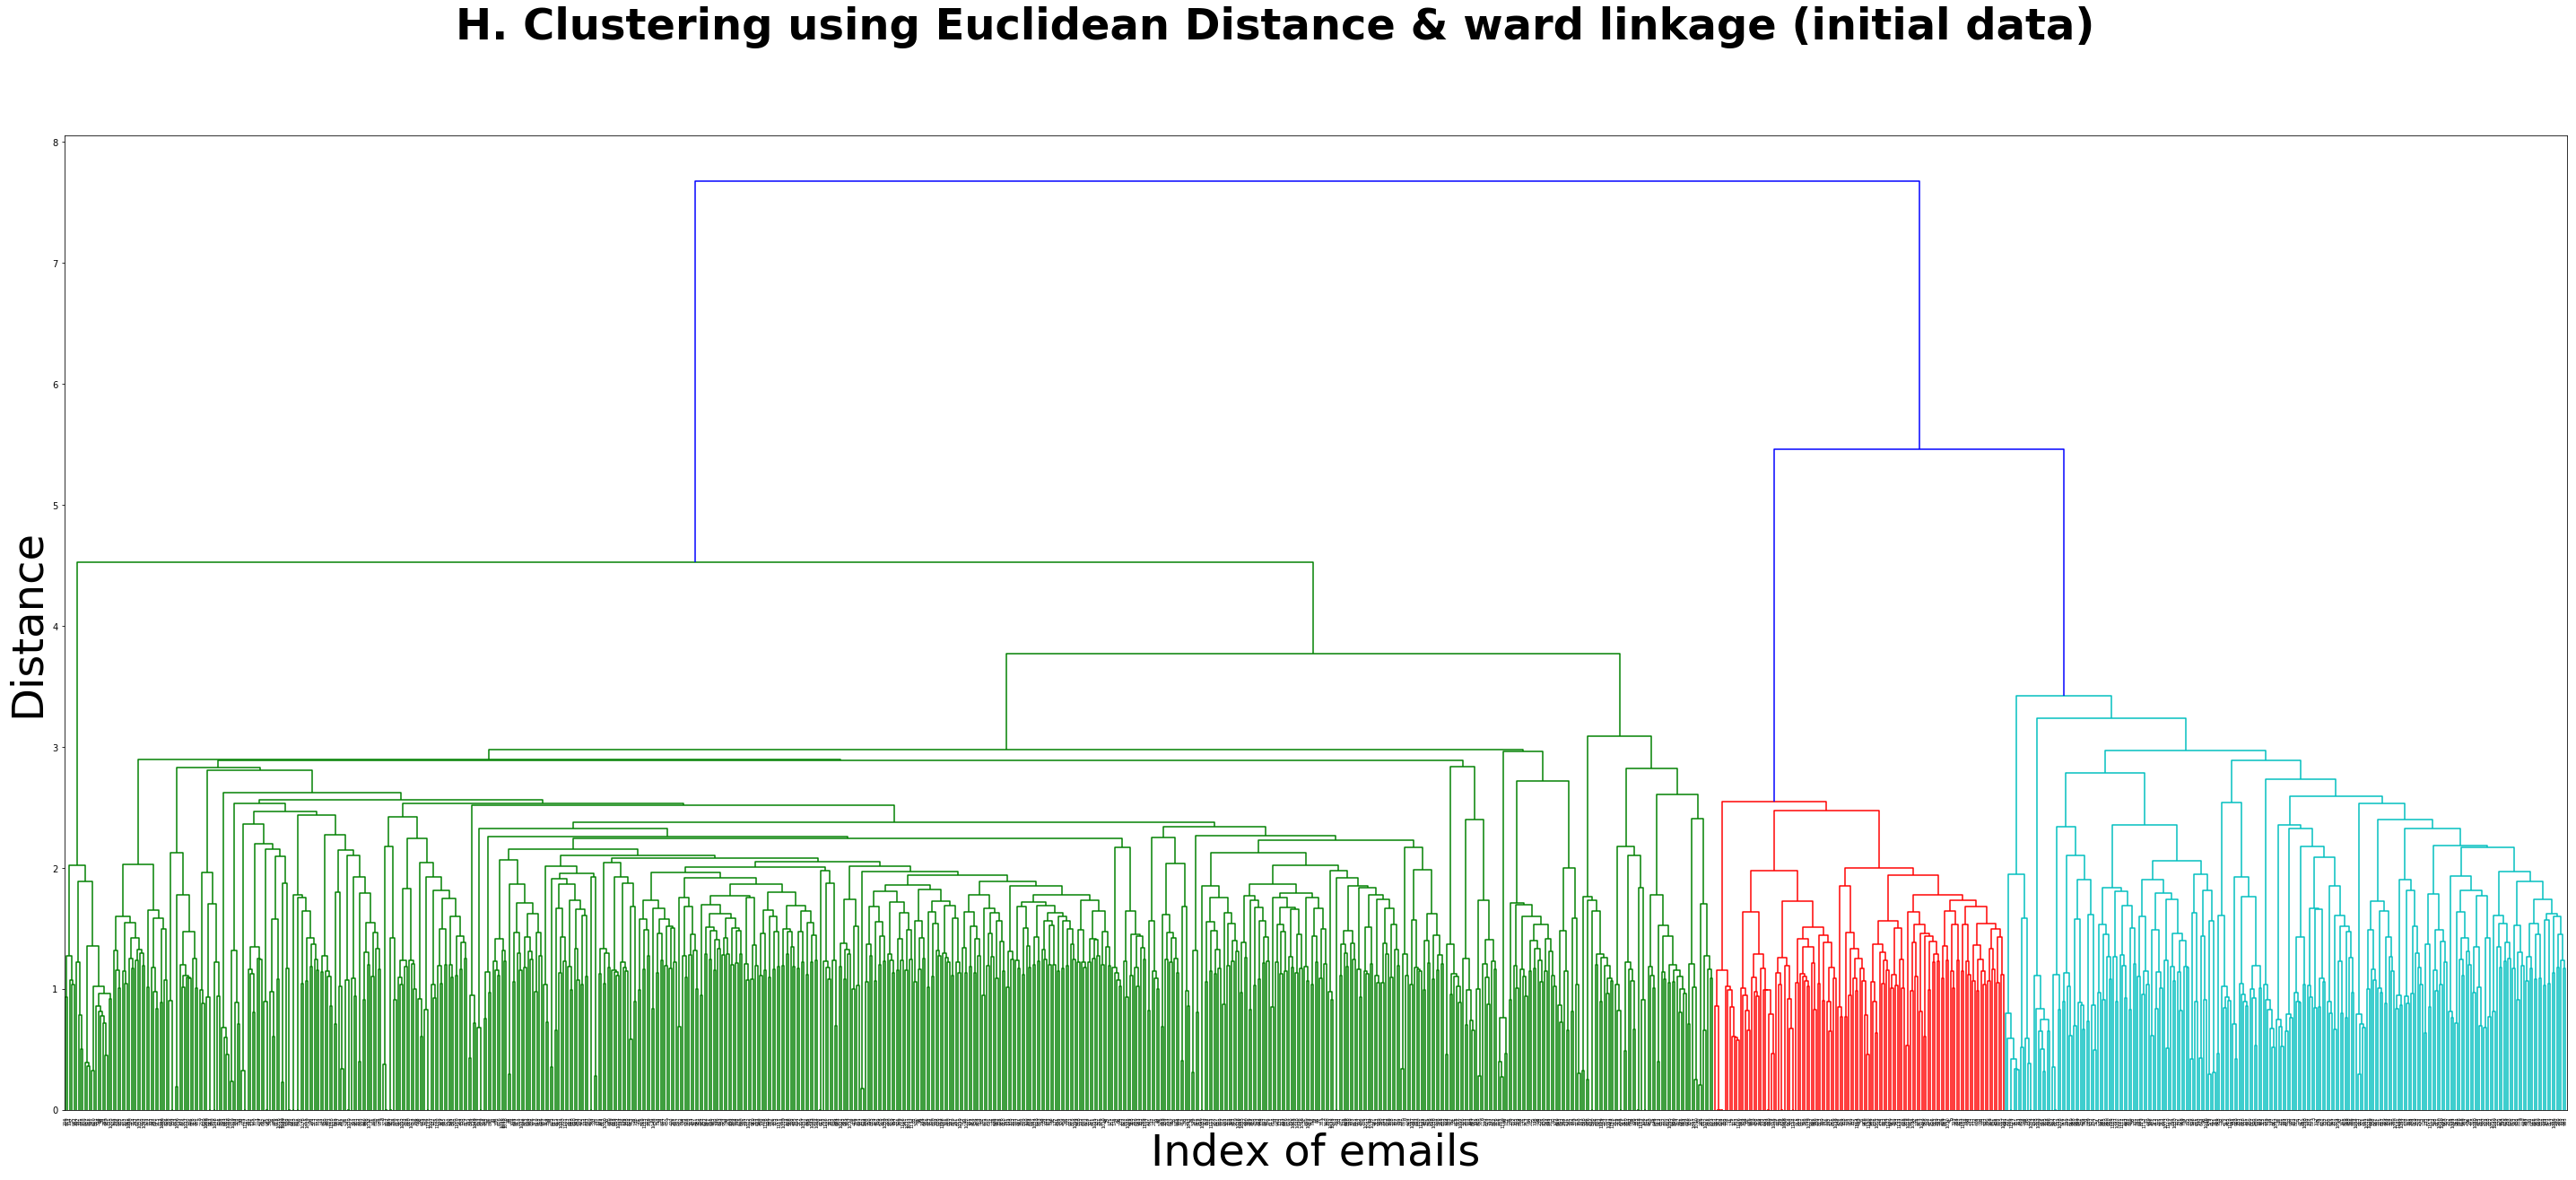

In [15]:
# Setting fugure size
plt.subplots(figsize=(50, 20))

plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Euclidean Distance & ward linkage (initial data)', fontweight='bold', fontsize=48);
dend1 = sch.dendrogram(sch.linkage(X.todense(), method='ward',  metric='euclidean'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC1L1.png")

In [20]:

#Reference : http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python
# Particularly for this cell

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">''<td style="background-color: {0}; ''border: 0;">''<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    #Extracting Color list and the index coordinates
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes


#Getting the clusters w.r.t. different colors
get_cluster_classes(dend1)

{'c': ['936',
  '1124',
  '701',
  '763',
  '317',
  '237',
  '691',
  '484',
  '578',
  '420',
  '1024',
  '796',
  '16',
  '555',
  '905',
  '329',
  '1063',
  '168',
  '896',
  '508',
  '154',
  '524',
  '627',
  '507',
  '133',
  '1058',
  '516',
  '717',
  '277',
  '969',
  '299',
  '988',
  '991',
  '426',
  '594',
  '452',
  '899',
  '29',
  '869',
  '134',
  '517',
  '527',
  '51',
  '592',
  '541',
  '665',
  '680',
  '836',
  '900',
  '797',
  '1062',
  '1103',
  '114',
  '662',
  '1112',
  '631',
  '262',
  '469',
  '95',
  '301',
  '342',
  '684',
  '679',
  '1117',
  '73',
  '689',
  '126',
  '431',
  '212',
  '713',
  '455',
  '513',
  '1073',
  '1110',
  '644',
  '294',
  '1050',
  '312',
  '731',
  '968',
  '702',
  '47',
  '792',
  '773',
  '702',
  '212',
  '679',
  '110',
  '598',
  '331',
  '655',
  '140',
  '643',
  '46',
  '1086',
  '146',
  '579',
  '412',
  '571',
  '486',
  '958',
  '270',
  '512',
  '465',
  '1119',
  '32',
  '384',
  '999',
  '741',
  '121',
  '497',
  '668',
  '557',
  '785',
  '540',
  '650',
  '622',
  '400',
  '185',
  '762',
  '197',
  '961',
  '18',
  '169',
  '291',
  '315',
  '181',
  '745',
  '33',
  '1032',
  '267',
  '603',
  '42',
  '997',
  '74',
  '417',
  '877',
  '402',
  '881',
  '1098',
  '232',
  '897',
  '139',
  '3',
  '102',
  '75',
  '229',
  '601',
  '755',
  '75',
  '250',
  '565',
  '241',
  '287',
  '324',
  '43',
  '351',
  '1014',
  '408',
  '998',
  '386',
  '559',
  '488',
  '525',
  '942',
  '371',
  '585',
  '1054',
  '1022',
  '1026',
  '256',
  '951',
  '839',
  '221',
  '867',
  '551',
  '769',
  '964',
  '362',
  '780',
  '378',
  '1010',
  '1131',
  '490',
  '1044',
  '176',
  '381',
  '274',
  '338',
  '434',
  '233',
  '575',
  '278',
  '919',
  '24',
  '155',
  '574',
  '1115',
  '548',
  '911',
  '472',
  '1060',
  '1069',
  '675',
  '950',
  '158',
  '1023',
  '282',
  '427',
  '984',
  '618',
  '949',
  '866',
  '56',
  '261',
  '247',
  '368',
  '1080',
  '425',
  '664',
  '223',
  '520',
  '573',
  '588',
  '972',
  '1055',
  '1089',
  '170',
  '954',
  '532',
  '290',
  '608',
  '284',
  '670',
  '476',
  '587',
  '458',
  '838',
  '4',
  '639',
  '285',
  '382',
  '10',
  '612',
  '856',
  '965',
  '669',
  '832',
  '344',
  '543',
  '403',
  '814',
  '767',
  '1005',
  '240',
  '280',
  '392',
  '993',
  '768',
  '458'],
 'g': ['206',
  '929',
  '37',
  '947',
  '104',
  '791',
  '938',
  '742',
  '264',
  '457',
  '858',
  '820',
  '391',
  '600',
  '784',
  '989',
  '59',
  '68',
  '398',
  '861',
  '721',
  '1003',
  '536',
  '935',
  '149',
  '505',
  '103',
  '561',
  '271',
  '360',
  '714',
  '1056',
  '243',
  '975',
  '410',
  '1042',
  '1052',
  '303',
  '712',
  '692',
  '915',
  '347',
  '397',
  '113',
  '1096',
  '550',
  '826',
  '634',
  '759',
  '388',
  '853',
  '1006',
  '777',
  '924',
  '120',
  '446',
  '1027',
  '147',
  '310',
  '931',
  '916',
  '255',
  '620',
  '5',
  '809',
  '963',
  '1008',
  '930',
  '1048',
  '111',
  '406',
  '663',
  '1068',
  '683',
  '438',
  '365',
  '1019',
  '328',
  '734',
  '333',
  '473',
  '1127',
  '99',
  '125',
  '160',
  '242',
  '281',
  '279',
  '547',
  '1',
  '21',
  '982',
  '682',
  '26',
  '466',
  '340',
  '518',
  '1016',
  '1093',
  '1099',
  '539',
  '746',
  '892',
  '681',
  '805',
  '831',
  '846',
  '27',
  '1078',
  '215',
  '1029',
  '54',
  '201',
  '117',
  '174',
  '323',
  '13',
  '462',
  '927',
  '1108',
  '440',
  '590',
  '621',
  '649',
  '251',
  '652',
  '707',
  '591',
  '1070',
  '76',
  '393',
  '901',
  '327',
  '152',
  '863',
  '127',
  '940',
  '586',
  '1033',
  '71',
  '356',
  '23',
  '939',
  '830',
  '375',
  '807',
  '8',
  '895',
  '907',
  '738',
  '920',
  '501',
  '1092',
  '514',
  '503',
  '928',
  '718',
  '736',
  '1011',
  '660',
  '66',
  '635',
  '628',
  '436',
  '1122',
  '724',
  '182',
  '725',
  '1007',
  '199',
  '217',
  '1120',
  '495',
  '821',
  '595',
  '842',
  '130',
  '370',
  '1100',
  '254',
  '758',
  '77

In [21]:
cluster_index = defaultdict(list)
for c, pi in zip(dend1['color_list'], dend1['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_index[c].append(int(i))

#Creating list of dataframes
list_of_values=[]
for k, v in cluster_index.items():
    list_of_values.append(v)

l_df=[]
for l in list_of_values:
    df_ = pd.concat([pd.DataFrame(l), df_flatlist], axis=1, join='inner')
    l_df.append(df_)


In [22]:
# len(l_df)
print("Output by Hierarchical clustering C1 - L1 \n")
list_l_df=[]

#For counting the numb er emails in each class
i=0
for l_d in l_df:
   
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering C1 - L1 

Total Emails in this cluster 0 = 770
Total Emails in this cluster 1 = 133
Total Emails in this cluster 2 = 260


In [23]:
def seg_clust(l1):
    wordlist2=[]
    wordlist2.append(no_punctuation(l1).split())
    seg=[]
    for w in wordlist2:
        no_integers = [x for x in w if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        pure_string=[x for x in no_integers if not any(c.isdigit() for c in x)]
        for s in pure_string:
            seg.append(segment(s))
    return(seg)

len_listofdf=len(list_l_df)

# LDA on the extracted dataframes

In [24]:
def data_prep_for_lda(i):
    d_comp=[]
    for d in list_l_df[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

In [25]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string


stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()


def clean(doc):
    
    #Removing words with length <3
    clean_str=[(re.sub(r'\b\w{1,3}\b', '', doc))]
    
    #Removing Empty elements
    clean_str=list(filter(None, clean_str))
    
    #Removing Stopwords
    stop_free = " ".join([i for i in str(clean_str).lower().split() if i not in stop])
    
    #Removing Punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
    #for stemming 
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    result = ''.join([i for i in normalized if not i.isdigit()])

    return result

doc_clean_new=[]

for i in range(0,len(l_df)):
    lists_cl=data_prep_for_lda(i)
    doc_clean_new.append([clean(doc).split() for doc in list(set(lists_cl))])
    

In [26]:
doc_clean_new1 = [list(chain(d)) for d in doc_clean_new]

In [27]:
# Importing Gensim
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
from gensim import corpora

In [28]:
# doc_clean_1 = [clean(doc).split() for doc in  list(chain(*doc1))] 
dictionary = gensim.corpora.Dictionary(list(chain(*doc_clean_new1)))

    # dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in list(chain(*doc_clean_new1))]
#
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=len(doc_clean_new1), id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(-1):
    print('\n Topic: {} \nWords: {}'.format(idx, topic))


 Topic: 0 
Words: 0.004*"watch" + 0.004*"rate" + 0.004*"price" + 0.004*"address" + 0.003*"personal" + 0.003*"friend" + 0.003*"website" + 0.002*"lender" + 0.002*"newsletter" + 0.002*"replica"

 Topic: 1 
Words: 0.004*"victim" + 0.004*"want" + 0.004*"part" + 0.004*"brand" + 0.004*"product" + 0.002*"quote" + 0.002*"need" + 0.002*"speed" + 0.002*"program" + 0.002*"report"

 Topic: 2 
Words: 0.004*"system" + 0.004*"service" + 0.004*"sale" + 0.004*"call" + 0.004*"offer" + 0.004*"cost" + 0.004*"saving" + 0.004*"client" + 0.004*"discount" + 0.003*"home"


### Computing Perplexity and coherence Score

In [29]:

#For evaluation of Topic models formed
from gensim.models import CoherenceModel

#For visualising LDA Output
import pyLDAvis
import pyLDAvis.gensim 

# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model.log_perplexity(bow_corpus)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list(chain(*doc_clean_new1)), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -8.764878775498373

 Coherence Score of the Spam Classification model:  0.8568366349454433


### Visualisation

In [26]:
print("LDA Output for Hierarchical clustering")
pyLDAvis.enable_notebook()
id2word=dictionary
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

LDA Output for Hierarchical clustering


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      33.726730        1       1  0.100444 -0.094980
2      33.266632        1       2 -0.134059 -0.037856
1      33.006641        1       3  0.033615  0.132835, topic_info=     Category      Freq       Term     Total  loglift  logprob
term                                                          
1047  Default  5.000000    service  5.000000  30.0000  30.0000
1170  Default  5.000000       home  5.000000  29.0000  29.0000
924   Default  5.000000   personal  5.000000  28.0000  28.0000
601   Default  5.000000     victim  5.000000  27.0000  27.0000
523   Default  5.000000      watch  5.000000  26.0000  26.0000
1173  Default  5.000000      price  5.000000  25.0000  25.0000
861   Default  5.000000    website  5.000000  24.0000  24.0000
727   Default  5.000000       sale  5.000000  23.0000  23.0000
1834  Default  5.000000     minute  5.000000  22.0000  22.0000
515   Default  5.000000   approval  5.000000  21.0000  21.0000
422   Default  5.000000     friend  5.000000  20.0000  20.0000
788   Default  5.000000       part  5.000000  19.0000  19.0000
1525  Default  5.000000       work  5.000000  18.0000  18.0000
1160  Default  5.000000       need  5.000000  17.0000  17.0000
1505  Default  4.000000     report  4.000000  16.0000  16.0000
1137  Default  5.000000     saving  5.000000  15.0000  15.0000
244   Default  4.000000       want  4.000000  14.0000  14.0000
217   Default  4.000000       rate  4.000000  13.0000  13.0000
90    Default  4.000000       call  4.000000  12.0000  12.0000
375   Default  3.000000      quote  3.000000  11.0000  11.0000
23    Default  3.000000       cost  3.000000  10.0000  10.0000
240   Default  3.000000   erection  3.000000   9.0000   9.0000
136   Default  3.000000     client  3.000000   8.0000   8.0000
224   Default  3.000000    address  3.000000   7.0000   7.0000
68    Default  3.000000      brand  3.000000   6.0000   6.0000
273   Default  3.000000    product  3.000000   5.0000   5.0000
409   Default  3.000000       site  3.000000   4.0000   4.0000
676   Default  3.000000      order  3.000000   3.0000   3.0000
404   Default  3.000000      angel  3.000000   2.0000   2.0000
456   Default  3.000000       year  3.000000   1.0000   1.0000
...       ...       ...        ...       ...      ...      ...
375    Topic3  3.204487      quote  3.754076   0.9502  -5.9517
244    Topic3  3.447276       want  4.060792   0.9447  -5.8787
240    Topic3  2.919374   erection  3.446490   0.9425  -6.0449
1079   Topic3  2.657218      taint  3.139355   0.9417  -6.1390
1525   Topic3  4.763531       work  5.628051   0.9417  -5.5552
1825   Topic3  2.648412   portugal  3.139224   0.9384  -6.1423
90     Topic3  3.425123       call  4.060548   0.9383  -5.8851
1430   Topic3  2.646408       sent  3.139198   0.9377  -6.1430
985    Topic3  2.643376     barker  3.139119   0.9366  -6.1442
577    Topic3  2.642703     serbia  3.139129   0.9363  -6.1444
904    Topic3  2.641154    russian  3.139077   0.9357  -6.1450
1975   Topic3  2.631881       your  3.138925   0.9323  -6.1485
1131   Topic3  2.630156    license  3.138887   0.9316  -6.1492
1307   Topic3  2.627642      senga  3.138849   0.9307  -6.1502
1092   Topic3  2.625750      enter  3.138826   0.9300  -6.1509
1116   Topic3  2.625688       path  3.138842   0.9300  -6.1509
876    Topic3  2.624512   shipping  3.138802   0.9295  -6.1513
713    Topic3  2.624309    czechia  3.138808   0.9294  -6.1514
790    Topic3  2.623849     wanted  3.138793   0.9293  -6.1516
413    Topic3  2.623549       burn  3.138793   0.9292  -6.1517
1497   Topic3  2.622966  container  3.138789   0.9289  -6.1519
1748   Topic3  2.622489  excitecom  3.138790   0.9287  -6.1521
424    Topic3  2.621142     chello  3.138742   0.9282  -6.1526
1212   Topic3  2.619929      leoma  3.138730   0.9278  -6.1531
676    Topic3  2.864021      order  3.445563   0.9236  -6.0640
1557   Topic3  2.859546       pil

# Version 2
# H. Clustering using Euclidean Similarity and Ward linkage


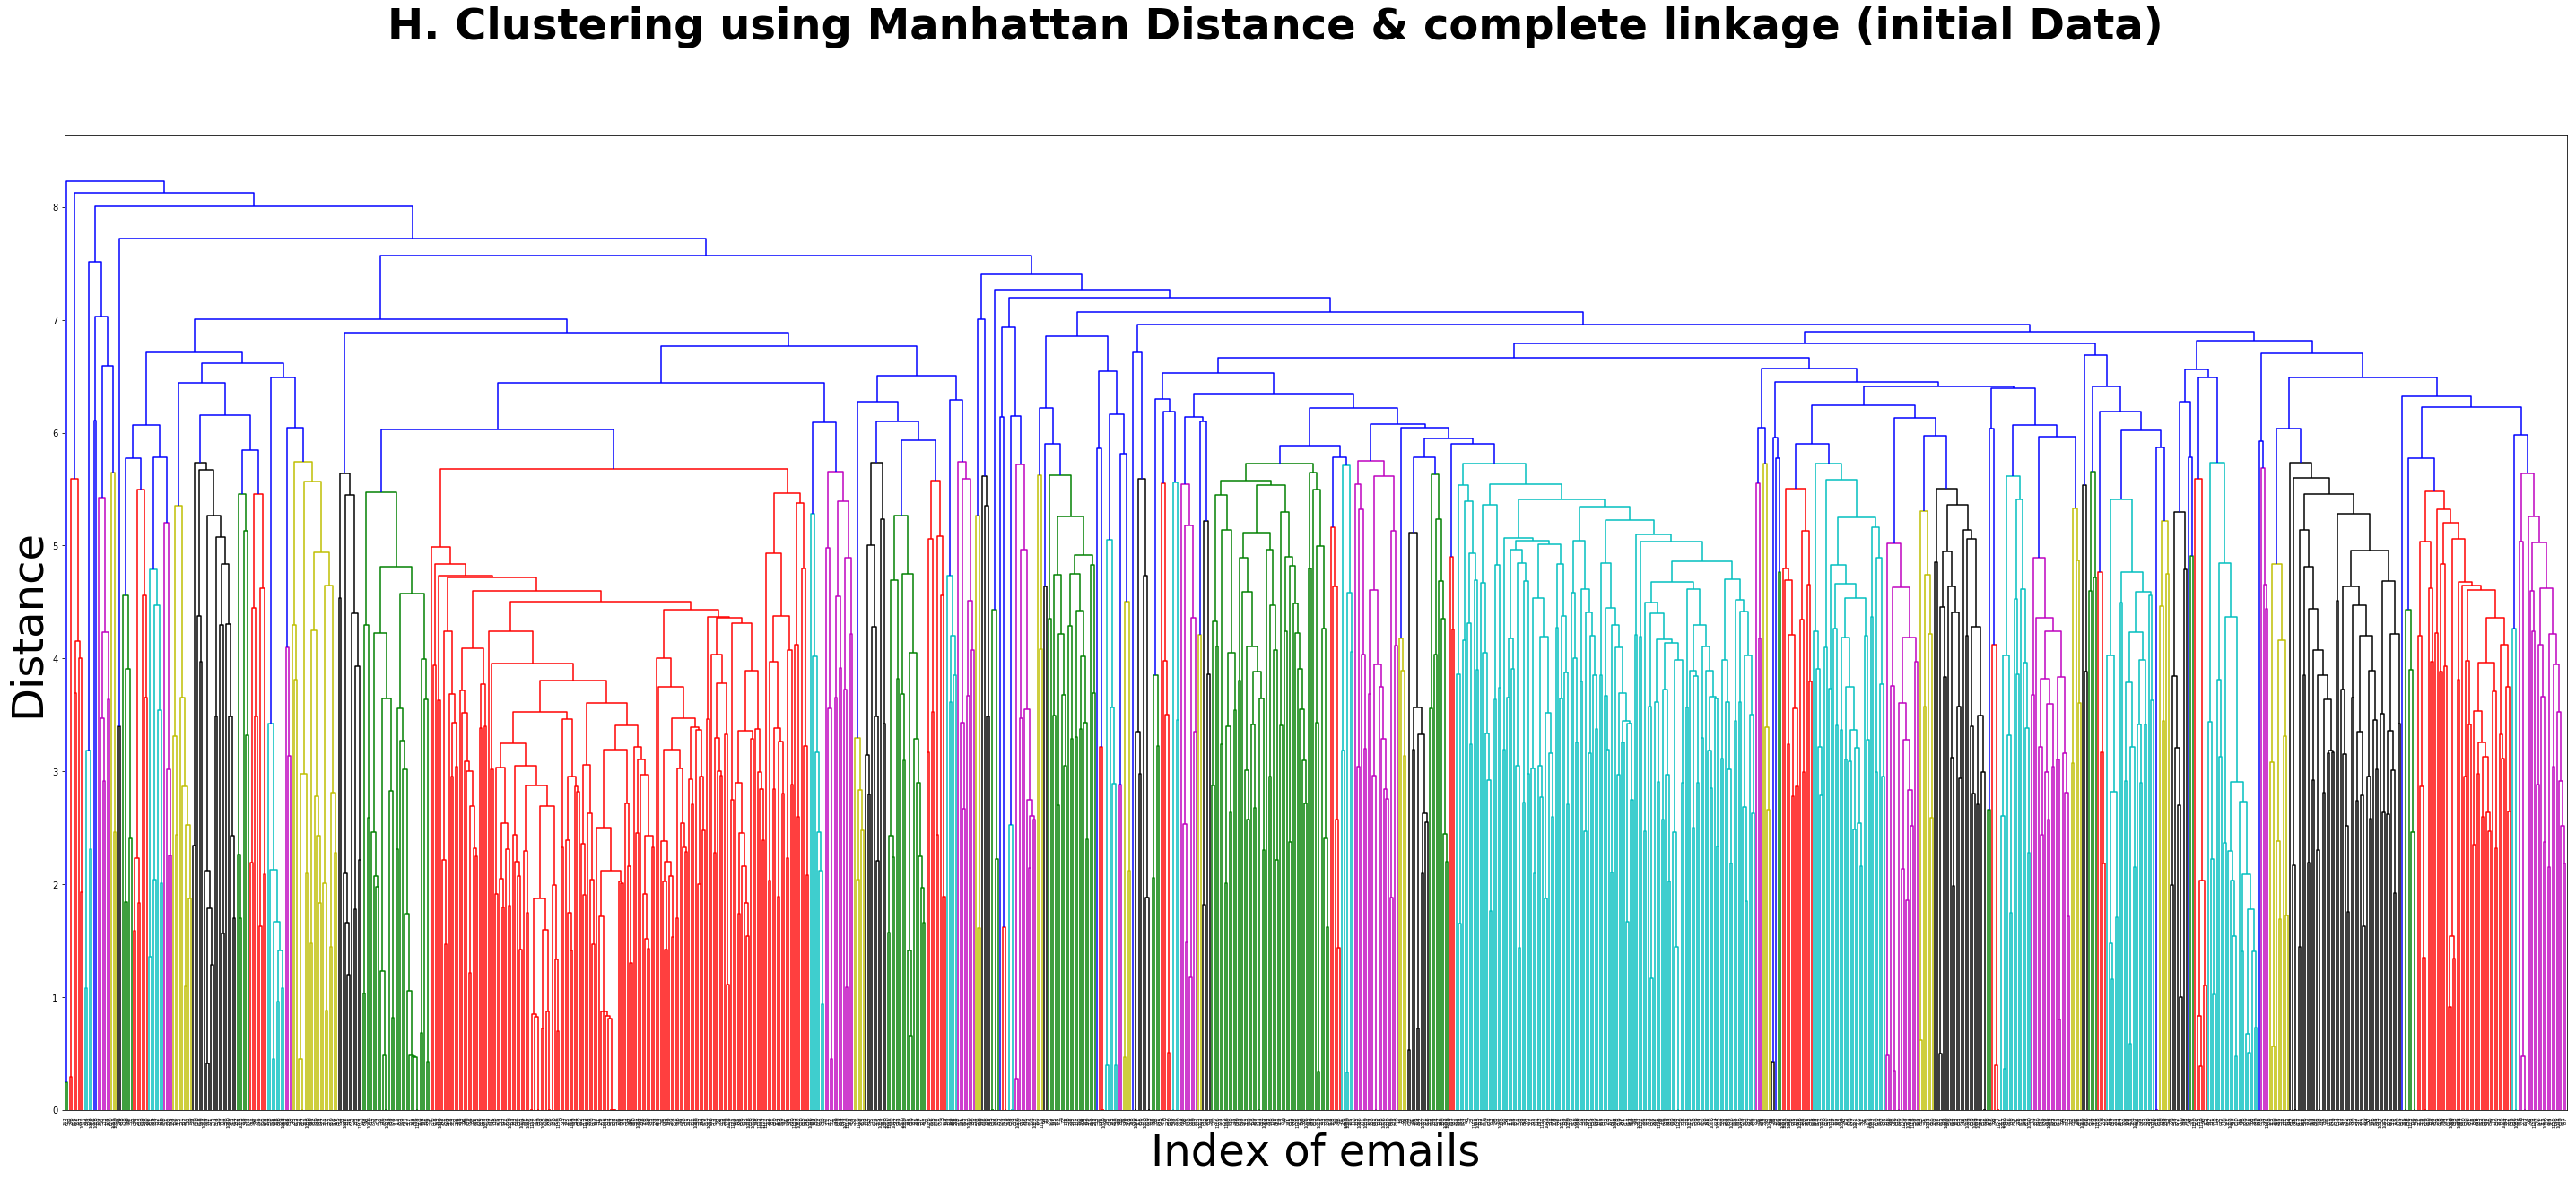

In [30]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# create dendrogram
plt.subplots(figsize=(50, 20))

plt.xlabel('Index of emails', fontsize=48)
plt.ylabel('Distance', fontsize=48)
plt.suptitle('H. Clustering using Manhattan Distance & complete linkage (initial Data)', fontweight='bold', fontsize=48);
dend2 = sch.dendrogram(sch.linkage(X.todense(), method='complete',  metric='cityblock'))
plt.savefig("../results_dendrograms_kmeans_visualisation/HC2L1.png")

In [31]:
# pd.__version__
get_cluster_classes(dend2)

g,"['167', '623', '408', '998', '43', '351', '488', '158', '1023', '282', '344', '543', '768', '140', '643', '46', '1086', '74', '417', '877', '402', '420', '1024', '796', '16', '484', '578', '368', '212', '713', '936', '1124', '763', '701', '317', '237', '691', '559', '455', '110', '598', '146', '579', '792', '1010', '1131', '490', '1044', '392', '993', '1060', '1069', '472', '384', '999', '741', '121', '497', '557', '668', '785', '767', '1044', '895', '907', '738', '920', '82', '572', '107', '295', '165', '722', '72', '198', '4', '238', '245', '306', '191', '202', '130', '276', '182', '199', '98', '200', '283', '215', '348', '955', '86', '841', '83', '500', '337', '1116', '303', '712', '927', '1108', '440', '590', '13', '462', '590', '699', '803', '313', '589', '481', '190', '467', '279', '433', '493', '862', '1087', '844', '387', '948', '461', '981', '109', '418', '719', '752', '2', '77', '331', '655', '60', '1005', '108', '725', '1125', '728', '647', '495', '990', '365', '1019', '633', '328', '734', '333', '765', '973', '325', '538', '239', '804', '1053', '1075', '180', '298', '567', '156', '533', '786', '917', '275', '904', '410', '714', '44', '265', '385', '868', '106', '432', '1123', '976']"
r,"['80', '266', '616', '672', '857', '1072', '761', '42', '997', '267', '603', '240', '280', '639', '427', '984', '56', '261', '588', '972', '520', '573', '810', '918', '143', '1030', '422', '624', '142', '218', '273', '22', '213', '259', '409', '956', '922', '945', '87', '389', '96', '593', '788', '626', '825', '873', '1071', '447', '545', '708', '775', '353', '597', '553', '829', '1079', '172', '852', '1001', '946', '233', '193', '441', '1017', '359', '376', '1134', '584', '889', '521', '379', '1045', '749', '876', '676', '816', '1130', '966', '345', '9', '395', '851', '1114', '225', '787', '294', '688', '499', '175', '1117', '882', '870', '967', '459', '638', '528', '562', '563', '994', '703', '1106', '101', '179', '11', '449', '471', '776', '124', '67', '686', '934', '383', '361', '1084', '369', '456', '716', '498', '435', '444', '740', '880', '549', '645', '735', '36', '230', '914', '799', '513', '921', '996', '396', '971', '673', '53', '771', '932', '293', '380', '747', '234', '479', '1088', '405', '224', '865', '1067', '575', '913', '58', '815', '93', '959', '1018', '248', '908', '537', '1133', '145', '326', '795', '1038', '607', '656', '710', '806', '1002', '744', '1107', '1102', '296', '709', '41', '262', '469', '301', '680', '114', '662', '569', '992', '114', '51', '592', '343', '690', '1112', '797', '1062', '1103', '541', '836', '665', '900', '27', '1078', '856', '965', '548', '911', '3', '102', '950', '583', '879', '974', '591', '1070', '76', '292', '860', '0', '429', '695', '26', '466', '340', '128', '518', '637', '987', '909', '360', '1042', '536', '935', '103', '561', '1021', '536', '1052', '148', '510', '1056', '793', '975', '271', '473', '1127', '99', '916', '5', '255', '620', '1128', '835', '1109', '116', '90', '112', '1100', '258', '629', '529', '711', '304', '189', '320', '660', '482', '779', '828', '995', '34', '943', '663', '1068', '438', '683', '246', '1083', '800', '970', '366', '451', '718', '736', '659', '985', '552', '883', '342', '850', '631', '707', '830', '79', '208', '1064', '187', '322', '845', '334', '687']"
c,"['732', '894', '129', '1049', '126', '431', '769', '964', '731', '968', '702', '555', '905', '168', '896', '329', '1063', '508', '168', '154', '540', '650', '622', '400', '762', '185', '1046', '123', '299', '136', '288', '194', '634', '759', '388', '97', '743', '468', '580', '195', '926', '460', '544', '355', '960', '61', '216', '1093', '1099', '135', '153', '546', '884', '453', '424', '577', '7', '25', '48', '183', '1025', '1111', '674', '733', '530', '6', '227', '192', '39', '720', '57', '1057', '260', '750', '54', '117', '119', '138', '314', '358', '957', '729', '891', '63', '437', '393', '901', '327', '693', '1121', '494', '30', '1043', '794', '978', '390', '214', '448', '321', '1011', '4

In [32]:
cluster_idxs_1 = defaultdict(list)
for c, pi in zip(dend2['color_list'], dend2['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs_1[c].append(int(i))



In [33]:
#Creating list of dataframes

list_of_values1=[]
for k, v in cluster_idxs_1.items():
    list_of_values1.append(v)

l_df1=[]
for l1 in list_of_values1:
    df_1 = pd.concat([pd.DataFrame(l1), data_subset], axis=1, join='inner')
    l_df1.append(df_1)


In [34]:
print("Output by Hierarchical clustering C2 - L1 \n")
list_l_df1=[]

i=0
for l_d in l_df1:
   
    print("Total Emails in this cluster", i,"=",len(l_d.values.tolist()))
    i+=1
    list_l_df1.append(l_d.iloc[:,1:].values.tolist())

Output by Hierarchical clustering C2 - L1 

Total Emails in this cluster 0 = 173
Total Emails in this cluster 1 = 295
Total Emails in this cluster 2 = 284
Total Emails in this cluster 3 = 13
Total Emails in this cluster 4 = 139
Total Emails in this cluster 5 = 84
Total Emails in this cluster 6 = 161


In [32]:
#Data Prep for the second combination of hierarchical clustering 
def data_prep2_for_lda(i):
    d_comp=[]
    for d in list_l_df1[i]:
        d_comp.append(''.join(str(d)))
    seg_cl=seg_clust(d_comp)
    lists_cl=[]
    for s_cl in seg_cl:
        lists_cl.append(' '.join(s_cl))
    return lists_cl

In [33]:
len_listofdf=len(list_l_df1)
doc_clean1=[]

for i in range(0,len(l_df1)):
    lists_cl1=data_prep2_for_lda(i)
    doc_clean1.append([clean(doc).split() for doc in list(set(lists_cl1))])
    
doc_cleean1=list(chain(*doc_clean1))

In [34]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary1 = corpora.Dictionary(doc_cleean1)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]
# doc_term_matrix
dictionary1 = gensim.corpora.Dictionary(doc_cleean1)

bow_corpus1 = [dictionary1.doc2bow(doc) for doc in doc_cleean1]
# bow_corpus
lda_model1 = gensim.models.LdaMulticore(bow_corpus1, num_topics=len(l_df1), id2word=dictionary1, passes=2, workers=2)

for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"great" + 0.024*"offer" + 0.021*"none" + 0.021*"best" + 0.017*"india" + 0.016*"call" + 0.014*"eliz" + 0.013*"emailcom" + 0.010*"mortgage" + 0.010*"looking"
Topic: 1 
Words: 0.096*"none" + 0.026*"state" + 0.017*"pfizer" + 0.015*"dont" + 0.015*"friend" + 0.013*"mining" + 0.011*"home" + 0.011*"julian" + 0.010*"enter" + 0.009*"marketing"
Topic: 2 
Words: 0.093*"spam" + 0.017*"email" + 0.015*"body" + 0.013*"kingdom" + 0.013*"system" + 0.013*"italy" + 0.012*"work" + 0.012*"harvest" + 0.011*"info" + 0.011*"price"
Topic: 3 
Words: 0.057*"brazil" + 0.025*"mail" + 0.020*"what" + 0.016*"france" + 0.013*"look" + 0.012*"serbia" + 0.009*"colombia" + 0.008*"check" + 0.008*"approval" + 0.007*"dorm"
Topic: 4 
Words: 0.038*"viagra" + 0.031*"china" + 0.027*"state" + 0.022*"notification" + 0.016*"your" + 0.015*"store" + 0.013*"sale" + 0.012*"style" + 0.012*"mortgage" + 0.010*"watch"
Topic: 5 
Words: 0.079*"state" + 0.034*"spam" + 0.025*"india" + 0.017*"dear" + 0.016*"mail" + 0.015*"

### Computing Perplexity and coherence score

In [35]:
# Compute Perplexity : lowest perplexity is considered the best.
perplexity=lda_model1.log_perplexity(bow_corpus1)
print('\n Perplexity of the Spam Classification model: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda1 = CoherenceModel(model=lda_model1, texts=doc_cleean1, dictionary=dictionary1, coherence='c_v')
coherence_lda1 = coherence_model_lda1.get_coherence()
print('\n Coherence Score of the Spam Classification model: ', coherence_lda)


 Perplexity of the Spam Classification model:  -7.471802355207818

 Coherence Score of the Spam Classification model:  0.8568455787506327


### Visualisation

In [36]:
pyLDAvis.enable_notebook()
id2word=dictionary1
vis = pyLDAvis.gensim.prepare(lda_model1, bow_corpus1, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      15.188382        1       1 -0.024000 -0.105662
2      15.081368        1       2 -0.214489  0.090995
5      14.922263        1       3 -0.115328 -0.005954
3      14.107519        1       4  0.178772  0.241524
1      14.023500        1       5  0.073175 -0.084844
0      13.797632        1       6  0.129560 -0.155433
6      12.879330        1       7 -0.027689  0.019374, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
10    Default  137.000000           spam  137.000000  30.0000  30.0000
136   Default  122.000000           none  122.000000  29.0000  29.0000
32    Default  139.000000          state  139.000000  28.0000  28.0000
146   Default   61.000000         brazil   61.000000  27.0000  27.0000
86    Default   49.000000         viagra   49.000000  26.0000  26.0000
57    Default   43.000000          india   43.000000  25.0000  25.0000
39    Default   58.000000          china   58.000000  24.0000  24.0000
34    Default   26.000000          great   26.000000  23.0000  23.0000
290   Default   25.000000   notification   25.000000  22.0000  22.0000
500   Default   20.000000           what   20.000000  21.0000  21.0000
116   Default   29.000000          offer   29.000000  20.0000  20.0000
407   Default   21.000000           best   21.000000  19.0000  19.0000
76    Default   56.000000           mail   56.000000  18.0000  18.0000
161   Default   18.000000           call   18.000000  17.0000  17.0000
278   Default   19.000000           dear   19.000000  16.0000  16.0000
219   Default   21.000000           body   21.000000  15.0000  15.0000
15    Default   17.000000          brand   17.000000  14.0000  14.0000
158   Default   23.000000       mortgage   23.000000  13.0000  13.0000
540   Default   16.000000           dont   16.000000  12.0000  12.0000
438   Default   20.000000         friend   20.000000  11.0000  11.0000
6     Default   22.000000          email   22.000000  10.0000  10.0000
74    Default   28.000000           sale   28.000000   9.0000   9.0000
311   Default   12.000000          phiri   12.000000   8.0000   8.0000
296   Default   14.000000        kingdom   14.000000   7.0000   7.0000
249   Default   25.000000         france   25.000000   6.0000   6.0000
85    Default   18.000000          store   18.000000   5.0000   5.0000
345   Default   15.000000           eliz   15.000000   4.0000   4.0000
474   Default   12.000000       emailcom   12.000000   3.0000   3.0000
139   Default   14.000000         poland   14.000000   2.0000   2.0000
323   Default   27.000000           your   27.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
72     Topic7    5.816419           foto    6.740104   1.9022  -5.0216
73     Topic7    5.815831       junction    6.740066   1.9021  -5.0217
60     Topic7    4.619979  rediffmailcom    5.356944   1.9015  -5.2519
454    Topic7    4.619654         russia    5.356925   1.9015  -5.2520
338    Topic7    4.619542          fedex    5.356914   1.9015  -5.2520
275    Topic7    4.619360           gint    5.356917   1.9014  -5.2520
90     Topic7    5.810469          money    6.739819   1.9012  -5.0226
28     Topic7    5.812759        chamber    6.747751   1.9004  -5.0222
22     Topic7    7.004523      wednesday    8.138908   1.8994  -4.8357
420    Topic7    5.811603         aolcom    6.753259   1.8994  -5.0224
51     Topic7    6.991183           save    8.138120   1.8976  -4.8376
668    Topic7    5.243505          kenya    6.179173   1.8854  -5.1253
433    Topic7    6.165060          order    7.283476   1.8828  -4.9634
665    Topic7    6.789258       customer    8.109109   1.8719  -4.8669
124    Topic7    9.838415       adolphus   12.536187   1.8072  -4.4960
115    Topic7    8.862040   prescription   11.195047   1.8159  